## Anomaly Detection - Compare all Models with Output

In [24]:
%reload_ext autoreload
%autoreload 2
import IPython, IPython.display, os, datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import ts_utils
import ts_plot_utils

import tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.callbacks  import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Lambda, Dropout, SimpleRNN, Dense, LSTM, RepeatVector, Input, TimeDistributed, concatenate
from keras import regularizers
from keras.utils import plot_model


mpl.rcParams['figure.figsize'] = (14, 4)
mpl.rcParams['axes.grid'] = True

print(f"Tensorflow Version {tf.__version__}, Keras Vesion: {keras.__version__}")

Tensorflow Version 2.10.0, Keras Vesion: 2.10.0


## Prepare Data

In [2]:
import glob
import numpy as np

def checkFirstColumnIsTime(df ):
    if (df.columns[0] != 'time'):
        v = df.iloc[0,0]
        print("Changing the first columns to time and converting to ms", v)
        
        df.columns = ['time'] + [c for c in df.columns[1:]]
        df['time'] = pd.to_datetime(df.time).map(lambda x: int(x.timestamp()*1000) ) 
    return df

def add_perodictime(df, day=1, quarter=1, year= 1):
    day = 24*60*60
    quarter = 4 * 30 * day
    year = (365.2425)*day

    if ( 'time' in df.columns):
        timestamp_s = df['time'] / 1000  # = > get it in seconds
    else:
        timestamp_s = df.index / 1000  # = > get it in seconds

    if ( day):
        df['Day_sin']     = np.sin(timestamp_s * (2 * np.pi / day))
        df['Day_cos']     = np.cos(timestamp_s * (2 * np.pi / day))
    if ( quarter):
        df['Quarter_sin'] = np.sin(timestamp_s * (2 * np.pi / quarter))
        df['Quarter_cos'] = np.cos(timestamp_s * (2 * np.pi / quarter))
    if ( year):
        df['Year_sin']    = np.sin(timestamp_s * (2 * np.pi / year))
        df['Year_cos']    = np.cos(timestamp_s * (2 * np.pi / year))

    return df;

#Comments Othe things you may do 
'''
    => Drop highly corrlated sensors for post-mortem analysis
    => Drop time correlated sensors 
    => reduce the frequency 
    => Add periodic sensors for day, month, quarter, year
'''
def read_data(files="/tmp/test/*.csv", dropna=True ):
    li=[]
    for f in (glob.glob(files)):
        df = pd.read_csv(f, index_col=None, header=0)
        print(f"Reading {f} ...")
        li.append(df)

    df = pd.concat(li, axis=0, ignore_index=True)

    if dropna:
        df.dropna(inplace=True)
    df = df.ffill().bfill().fillna(0)    # <= we would already dropped NAs before

    df = checkFirstColumnIsTime(df)
    df.index= df['time']
    df.sort_index(inplace=True)

    df.drop('time', axis=1, inplace=True, errors="ignore")

    return df



In [8]:
import ts_transform
from ts_transform import myColumnTransformer

# Read the file
files = "/tmp/test/*SAMPLE*.csv"
df = read_data(files=files, dropna=True )
df = add_perodictime(df)
df.index = pd.to_datetime(df.index, unit='ms')

# Remove unneeded 
remove_columns = "atime yltime ypw ctemp2 ctime".split()
df.drop(remove_columns, axis=1, inplace=True)

split  = int(len(df) * .7)

df1 = df
df_trn1  = df[df.columns[1:]][:split]
df_tst1  = df[df.columns[1:]][split:]

# See ts_transofrm for more details on how to use this
scaler, df_trn = myColumnTransformer.scale_df(df_trn1)
df_tst = scaler.transform(df_tst1)
df_trn.index = df_trn1.index
df_tst.index = df_tst1.index
scaler.save(os.path.dirname(files) + "/SCALER." )  # <== we can read this later if we wanted to 
df_tst

ValueError: No objects to concatenate

In [7]:
#Lets remvoe all the positional encoding features
output_feat_len = len(scaler.numerics);

for c in "Day_sin Day_cos Quarter_sin Quarter_cos Year_sin Year_cos".split():
    if c in df_trn.columns:
        output_feat_len  -= 1
    print(c, c in df_trn.columns, output_feat_len)

input_slice  = slice(0, len(df_trn.columns))
label_slice  = slice(0, output_feat_len)
window_len   = 48
output_len   = 1
batch_size   = 20

inp_feat_len = input_slice.stop - (input_slice.start or 0)
input_shape  = (window_len, inp_feat_len)
model_op_len = output_feat_len * output_len

ds_trn = tf.data.Dataset.from_tensor_slices(df_trn[df_trn.columns[input_slice]])
ds_tst = tf.data.Dataset.from_tensor_slices(df_tst[df_tst.columns[input_slice]])
window_trn = ts_utils.window(ds_trn, window_len, output_len, label_slice, batch_size=batch_size, skip=0)
window_tst = ts_utils.window(ds_tst, window_len, output_len, label_slice, batch_size=batch_size, skip=0)
window_trn100 = ts_utils.window(ds_trn, window_len, output_len, label_slice, batch_size=100000, skip=0)
window_tst100 = ts_utils.window(ds_tst, window_len, output_len, label_slice, batch_size=100000, skip=0)


print(f'''
    input_shape     :    {input_shape}
    #input Features :    {len(df_trn.columns)}
    #Out Features   :    {output_feat_len}
    #Model outputs  :    {model_op_len}
    # Training data :    { len(ds_trn)} 
    # Testing data  :    { len(ds_tst)} 
    #Window Lenght  :    { window_len}
    #predictions    :    {output_len}
    #batch_size     :    {batch_size}
''')

NameError: name 'scaler' is not defined

## Various Models

In [4]:
import tensorflow
from tensorflow import keras
from keras import layers
models = {}

In [5]:
'''x = np.array(   
       [
         [[1., 2., 3.], [10., 20., 30.] ],
         [[1., 2., 3.], [11., 22., 33.] ]
        ]
    )
l = layers.Flatten(input_shape= x.shape)    
x.shape, l(x), x[:, -1:, :], l.trainable''';

In [10]:
# Flattened Linear Model
model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    #layers.Lambda(lambda x: x[:, -1:, :]),
        layers.Flatten(input_shape= [4,2]), 
        Dense( np.prod([4,2]), activation="relu"),
    ]+ ts_utils.getCommonLayer(3, 4),
    name = "FlattenLinear"
)
models[model.name] = {"model": model}

In [20]:
f=tf.keras.utils.plot_model(model, show_shapes=True, to_file='model.svg')


ValueError: Cannot embed the 'svg' image format

In [23]:
!ls *.svg

19316.25s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


model.svg


In [6]:
a# Flattened Linear Model
model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    #layers.Lambda(lambda x: x[:, -1:, :]),
        layers.Flatten(input_shape= input_shape), 
        Dense( np.prod(input_shape), activation="relu"),
    ]+ ts_utils.getCommonLayer(output_len, output_feat_len),
    name = "FlattenLinear"
)
models[model.name] = {"model": model}


NameError: name 'input_shape' is not defined

In [9]:
# Linear Model
model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    #layers.Flatten(input_shape= input_shape), 
    layers.Lambda(lambda x: x[:, -1:, :]),
    ]+ ts_utils.getCommonLayer(output_len, output_feat_len),
    name = "Linear"
)
models[model.name] = {"model": model}


In [10]:
# LSTM Model
model = tf.keras.Sequential([
        # Shape [batch, time, features] => [batch, lstm_units].

        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64, return_sequences=False)
    ]+ ts_utils.getCommonLayer(output_len, output_feat_len),
    name = "LSTM"
)
models[model.name] = {"model": model}


In [11]:
#Simple RNN
model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(40)
    ]+ ts_utils.getCommonLayer(output_len, output_feat_len),
    name="SimpleRNN")

models[model.name] = {"model": model}

# Add a Dense Layer
model = tf.keras.Sequential([
        # Take the last time-step.
        # Shape [batch, time, features] => [batch, 1, features]
        tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
        tf.keras.layers.Dense(512, activation='relu')
    ]+ ts_utils.getCommonLayer(output_len, output_feat_len),
    name = "DenseLinear"
)
models[model.name] = {"model": model}


# CNN
CONV_WIDTH = 3
model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    ]+ ts_utils.getCommonLayer(output_len, output_feat_len),
    name = "Conv"
)
models[model.name] = {"model": model}


In [12]:
# Uber Model
dim = 128

# Create Autoencoder Layer
input_layer = Input(shape=(window_len, inp_feat_len), dtype='float32', name='input')
memory_layer = LSTM(dim, return_sequences=True)(input_layer)
memory_layer = LSTM (dim//2, return_sequences=False)(memory_layer)
repeated_lyr = RepeatVector(window_len)(memory_layer)
memory_layer = LSTM (dim//2, return_sequences=True)(repeated_lyr)
memory_layer = LSTM (dim,  return_sequences=True)(memory_layer)
decoded_inputs = TimeDistributed(Dense(units=inp_feat_len, activation='linear'))( memory_layer)

dropout_input = Dropout(0.2)(input_layer)
concat_layer = concatenate([dropout_input, decoded_inputs])
memory_layer = LSTM(units=dim, 
                    kernel_regularizer = regularizers.l1_l2(l1= 0, l2= 0), 
                    recurrent_regularizer = regularizers.l1_l2(l1= 0, l2= 0), 
                    return_sequences=False)(concat_layer)

# => Note this is same as getCommonLayer(ouput_len, ouput_feat_len, memory_layer)
#
# preds = Dense(units=ouput_feat_len*ouput_len)(memory_layer)
preds = Dense(units=output_feat_len*output_len, activation='linear')(memory_layer)
preds = tf.keras.layers.Reshape([output_len, output_feat_len])(preds)
model = Model(input_layer, preds, name="Uber")

# => UNCOMMEN IF decide to do Uber model it takes long time to build this model

models[model.name] = {"model": model}
#history = ts_utils.compile_fit(model, window_trn, window_tst, epochs=1, verbose=1)


## Transformer

In [13]:
import tensorflow
from tensorflow import keras
from keras import layers

'''
    input shape = windows_len, features_length  <== this is your input features dimentions
    output shape= output_len , ouput_feat_len   <== This is your output features dimentions
'''
class TransformerModel():
    def __init__(self, window_len, feat_len, output_len, ouput_feat_len, head_size=256, 
                num_heads=6, ff_dim=64, num_transformer_blocks=6, mlp_units=[128], 
                dropout=0.3, mlp_dropout=0.25, use_norm= "layer|batch", **kwargs ):
        super().__init__()
        input_shape = (window_len, feat_len)
        self.input_shape = input_shape
        self.output_len, self.ouput_feat_len, self.head_size, self.num_heads, \
            self.ff_dim,self.num_transformer_blocks, self.mlp_units, self.dropout, self.mlp_dropout = \
                  output_len, ouput_feat_len, head_size, num_heads, ff_dim, \
                num_transformer_blocks, mlp_units, dropout, mlp_dropout

        self.mha = [layers.MultiHeadAttention(key_dim=feat_len, num_heads=num_heads, dropout=dropout, name="mha")] *num_transformer_blocks
        self.layernorm = [layers.LayerNormalization()] * num_transformer_blocks
        self.add = layers.Add()

        self.ff = [ Sequential([
                    layers.Dense(ff_dim, activation='relu'),
                    layers.Dense(feat_len),
                    layers.Dropout(mlp_dropout)] , name="FeedForward")
                    ]  * num_transformer_blocks

        op_len = output_len * ouput_feat_len
        
        self.last = Sequential([layers.Flatten(), 
                                layers.Dropout(mlp_dropout), 
                                layers.Dense( op_len, activation="relu"),
                                layers.Reshape([output_len, ouput_feat_len])],
                                name = "LastDecoderLyer")
        self.build()

    def position_encoding(self, x):
        return x

    def ff(self, inputs):
        x = self.ff (inputs)
        x = self.layernorm(x)
        self.add( [inputs, x])
        return x

    def build(self, inputs =None):
        if inputs is None:
            inputs = keras.Input(shape=self.input_shape)
        x = self.position_encoding(inputs)

        for i in range( self.num_transformer_blocks ):
            x = self.mha[i](inputs, inputs, inputs )
            x = self.layernorm[i](x)
            self.add( [x, inputs])
            x = self.ff[i](x)

        x = self.last(x)
        return keras.Model(inputs, x, name="transformer")

tm = TransformerModel(input_shape[0], input_shape[1], output_len, output_feat_len)
model = tm.build()
models[model.name] = {"model": model}
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 28)]     0           []                               
                                                                                                  
 mha (MultiHeadAttention)       (None, 48, 28)       19348       ['input_2[0][0]',                
                                                                  'input_2[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 layer_normalization (LayerNorm  (None, 48, 28)      56          ['mha[11][0]']                   
 alization)                                                                             

## Compile and Evaluate All Models

In [17]:
recompile, i, e = 0, 0 , 12
for m, modelp in models.items():
    t1= datetime.datetime.now()
    model = modelp['model']
    i += 1
    print(f"Now Compiling {i}/{len(models)} {model.name} ")
    history = ts_utils.compile_fit(model, window_trn, window_tst, epochs=e, verbose=1)
    IPython.display.clear_output()
    t2= datetime.datetime.now()
    modelp['compile_start'] = t1
    modelp['compile_ended'] = t2
    modelp['compile_time' ] = str(t2 - t1)
    modelp['history' ] = history
    print(f"It took {str(t2 - t1)} to compile {model.name}")

# Plot graphs
# ts_plot_utils.plot_performance1(models, window_trn, window_tst, models=models)

It took 0:11:44.104812 to compile transformer


Now Compiling 8 FlattenLinear True
Now Compiling 8 Linear True
Now Compiling 8 LSTM True
Now Compiling 8 SimpleRNN True
Now Compiling 8 DenseLinear True
Now Compiling 8 Conv True
Now Compiling 8 Uber True
Now Compiling 8 transformer True


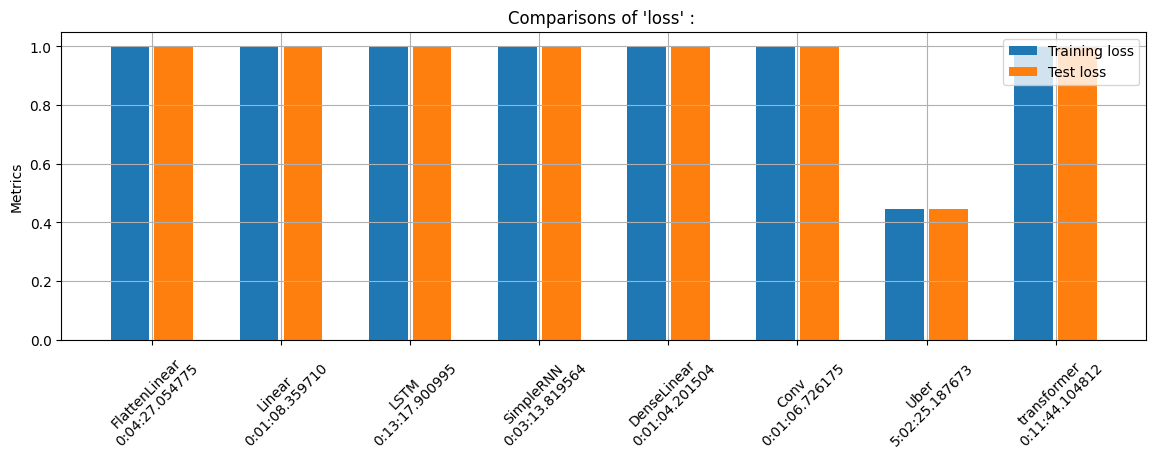

In [18]:
ts_plot_utils.plot_performance1(models, window_trn100, window_tst100 );

In [24]:
dfvals=[]
for m, mp in models.items():
    m = mp['model']
    v = [m.name, mp['compile_time'], m.count_params(), mp['train_eval'], mp['test_eval']]
    dfvals.append(v)

pd.DataFrame(dfvals,columns="ModelName  compile_time, num_params, train_err test_err".split())

,ModelName,"compile_time,","num_params,",train_err,test_err
0,FlattenLinear,0:04:27.054775,1837270,1.000154,0.821769
1,Linear,0:01:08.359710,638,1.000154,0.821769
2,LSTM,0:13:17.900995,58262,1.000154,0.821769
3,SimpleRNN,0:03:13.819564,3662,1.000154,0.821769
4,DenseLinear,0:01:04.201504,26134,1.000154,0.821769
5,Conv,0:01:06.726175,27414,1.000154,0.821769
6,Uber,5:02:25.187673,362802,0.444745,0.340952
7,transformer,0:11:44.104812,52670,1.000154,0.821769


## Model Architecture

In [ ]:
from keras.utils import plot_model
for m, modelp in models.items():
    model = modelp['model']
    print(f"PLotting {i} Model: {model.name}")
    d= plot_model(model, show_shapes=True)
    display(d)

## Predictions

In [32]:
for m, modelp in models.items():
    model = modelp['model']
    modelp['train_predictions'] = modelp['train_predict']
    modelp['test_predictions'] = modelp['test_predict']


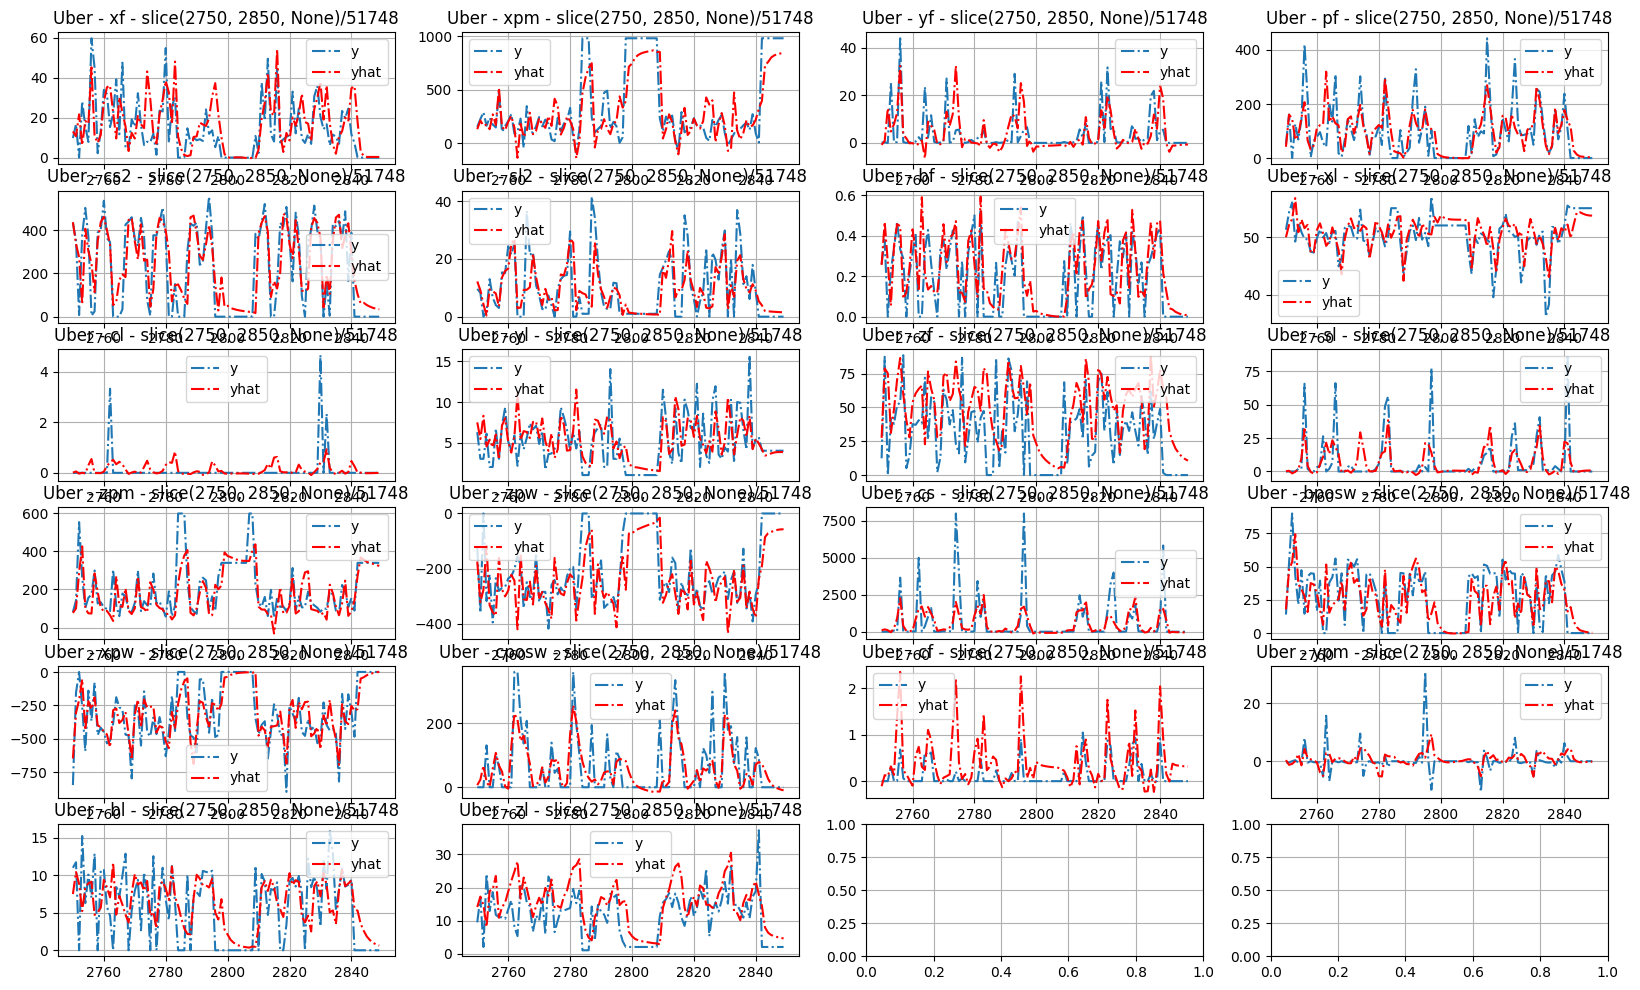

In [27]:
import matplotlib.pyplot as plt

modelp = models["Uber"]
model = modelp["model"]

assert model is not None, "No model!@"

if not modelp.get('test_predictions', None):
    y, yhat = ts_utils.model_predict( model , window_tst100)
y, yhat = modelp['test_predictions']

ydf = pd.DataFrame(y, columns=scaler.feature_names_in_[label_slice])
pdf = pd.DataFrame(yhat, columns=scaler.feature_names_in_[label_slice])
ydf = scaler.inverse_transform(ydf)
pdf = scaler.inverse_transform(pdf)


rw=slice(2750, 2850)
pc = 4
nc = len(ydf.columns)
pr = nc //pc 
pr += 1 if len(ydf.columns)%pc else 0
fig, axs = plt.subplots(pr, pc, figsize=(20, 3 *pc))
for i, c in enumerate(ydf.columns):
    pr1 , pc1 = i // pc, i % pc
    plt1 = axs[ pr1, pc1 ]
    plt1.plot(range(len(ydf))[rw], ydf[c][rw], "-."  , label=f"y")
    plt1.plot(range(len(pdf))[rw], pdf[c][rw], "r-." , label=f"yhat")
    plt1.legend()
    plt1.set_title(f'{model.name} - {c} - {rw}/{len(ydf)}')

In [ ]:
#model = models[1]
#ydf, pdf = ts_plot_utils.predict_and_plot( model, window_trn100, window_tst100, howmany=1024* 1024,
#                        plot_start=0, df=None, scaler=None, label_slice=None);

## Anomaly graph

In [126]:
# Read the anomlay database

LDATA="/opt/data/tseries/data/mazak/"
MACHINE= 'gp-mazak-i300-5'

anoms = f'{LDATA}{MACHINE}-SAP.csv'
dfa = pd.read_csv(anoms)
dfa.sort_values(by="Actual Start")
dfa['Actual Start'] = pd.to_datetime(dfa['Actual Start'], format="%Y%m%d")
dfa['Actual End'] = pd.to_datetime(dfa['Actual End'], format="%Y%m%d")
dfa.sort_values(by="Actual Start", inplace=True)
dfa.reset_index(inplace=True, drop=True)
dfa[3:]

,Unnamed: 0,Acquisition Date,Actual End,Actual Start,Basic Finish,Basic Start,Building (combined),Created By,Created On,DAMAGE,...,Wo Type,Wo Type Desc,Work Order,Work Order,Acquisition Value,Actual Cost,Downtime,EQUIP_BUILDING_LATITUDE,EQUIP_BUILDING_LONGITUDE,Number of Breakdowns
3,15254,0.0,2021-06-10,2021-05-26,0,20210526,010 | BUILDING 10 (MANUFACTURING),E344624,20210526,NaN,...,503,BLDG. AND GROUNDS,10752310,10752310,0.0,5932.26,20.0,32.715748,-97.030548,1
4,15086,0.0,2022-02-28,2022-02-15,0,20220215,010 | BUILDING 10 (MANUFACTURING),RMSNETUSR,20220215,NaN,...,503,BLDG. AND GROUNDS,10785880,10785880,0.0,828.87,1.5,32.715748,-97.030548,1
5,15672,0.0,2022-05-02,2022-04-21,0,20220420,010 | BUILDING 10 (MANUFACTURING),DIDUCH,20220420,NaN,...,503,BLDG. AND GROUNDS,10794863,10794863,0.0,822.24,2.0,32.715748,-97.030548,1
6,15256,0.0,2022-09-13,2022-09-06,0,20220906,010 | BUILDING 10 (MANUFACTURING),RMSNETUSR,20220906,NaN,...,503,BLDG. AND GROUNDS,10813058,10813058,0.0,448.30,0.5,32.715748,-97.030548,1
7,15085,0.0,2022-09-21,2022-09-13,0,20220913,010 | BUILDING 10 (MANUFACTURING),LOPEZVM,20220913,NaN,...,503,BLDG. AND GROUNDS,10813938,10813938,0.0,598.51,0.5,32.715748,-97.030548,1
8,15255,0.0,2022-09-27,2022-09-19,0,20220919,010 | BUILDING 10 (MANUFACTURING),RMSNETUSR,20220919,NaN,...,503,BLDG. AND GROUNDS,10814391,10814391,0.0,448.30,1.0,32.715748,-97.030548,1
9,15258,0.0,2022-10-11,2022-09-27,0,20220927,010 | BUILDING 10 (MANUFACTURING),LOPEZVM,20220927,NaN,...,503,BLDG. AND GROUNDS,10815128,10815128,0.0,448.30,1.0,32.715748,-97.030548,1
10,15257,0.0,2022-11-03,2022-10-24,0,20221024,010 | BUILDING 10 (MANUFACTURING),LOPEZVM,20221024,NaN,...,503,BLDG. AND GROUNDS,10819257,10819257,0.0,224.15,2.0,32.715748,-97.030548,1
11,15746,0.0,2023-01-18,2023-01-03,0,20230103,010 | BUILDING 10 (MANUFACTURING),HATTON,20230103,NaN,...,511,Machinery & Equipment,10829266,10829266,0.0,8882.82,80.0,32.715748,-97.030548,1


,xf,xpm,yf,pf,cs2,sl2,bf,xl,cl,yl,...,zpm,zpw,cs,bposw,xpw,cposw,cf,ypm,bl,zl
count,1.208090e+05,1.208090e+05,1.208090e+05,1.208090e+05,1.208090e+05,1.208090e+05,1.208090e+05,1.208090e+05,1.208090e+05,1.208090e+05,...,1.208090e+05,1.208090e+05,1.208090e+05,1.208090e+05,1.208090e+05,1.208090e+05,1.208090e+05,1.208090e+05,1.208090e+05,1.208090e+05
mean,4.697855e-01,9.155936e-01,8.684683e-02,4.538934e-01,7.127969e-01,5.978738e-01,5.820040e-01,5.688311e-01,2.105073e-01,6.580617e-01,...,8.208143e-01,6.674831e-01,3.679675e-01,7.595523e-01,7.292880e-01,7.115325e-01,8.356893e-02,2.119516e-01,7.250047e-01,6.804722e-01
std,8.829901e-01,4.023456e-01,9.964247e-01,8.912672e-01,7.016021e-01,8.018039e-01,8.134066e-01,8.201682e-01,9.777972e-01,7.531832e-01,...,5.715008e-01,7.448928e-01,9.300478e-01,6.506812e-01,6.844373e-01,7.028834e-01,9.967051e-01,9.774863e-01,6.889740e-01,7.329314e-01
min,1.391666e-06,9.545176e-04,2.039959e-05,3.400764e-05,2.544085e-04,3.363339e-04,6.862052e-04,1.115079e-04,1.068833e-01,1.685055e-03,...,8.217947e-05,7.502023e-04,1.698574e-03,1.506961e-03,3.548876e-05,3.194329e-04,8.952904e-06,4.472256e-05,1.484440e-02,1.568642e-04
25%,2.918110e-01,7.187144e-01,4.855452e-02,2.635018e-01,4.389028e-01,3.886317e-01,3.324035e-01,2.264435e-01,1.068833e-01,4.251983e-01,...,3.622876e-01,8.735518e-02,1.979329e-01,4.888012e-01,4.653647e-01,4.422359e-01,4.441117e-02,1.011033e-01,4.606154e-01,4.396203e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75%,2.918110e-01,8.484869e-01,4.855452e-02,2.635018e-01,4.389028e-01,3.886317e-01,3.324035e-01,4.211207e-01,1.068833e-01,7.241489e-01,...,1.330005e+00,1.437762e+00,1.979329e-01,4.888222e-01,4.653647e-01,4.422359e-01,4.441117e-02,1.024465e-01,4.606154e-01,5.477623e-01
max,8.253466e+01,4.046018e+00,3.365941e+02,6.037997e+01,1.171991e+01,2.220614e+01,2.039595e+01,4.675530e+00,4.907933e+01,2.887196e+01,...,5.530498e+00,4.544239e+00,1.842055e+01,7.924977e+00,5.993544e+00,3.356528e+00,5.730824e+01,1.619068e+01,3.305930e+01,2.291904e+01
fscore,-3.466391e+02,-3.466093e+02,-3.466448e+02,-3.466401e+02,-3.466316e+02,-3.466345e+02,-3.466373e+02,-3.459217e+02,-3.466441e+02,-3.466325e+02,...,-3.466361e+02,-3.466444e+02,-3.466422e+02,-3.466284e+02,-3.466300e+02,-3.466314e+02,-3.466448e+02,-3.466445e+02,-3.466303e+02,-3.466152e+02
std_mean,-5.717292e-13,1.181384e-14,5.934062e-14,6.422983e-13,1.195950e-12,8.042401e-13,7.158012e-13,8.620050e-14,1.820148e-13,1.637547e-13,...,8.366635e-14,-1.029534e-12,1.625348e-13,1.953520e-12,-6.283536e-13,-1.766619e-12,3.232338e-14,-3.767295e-13,8.174575e-13,1.163425e-12


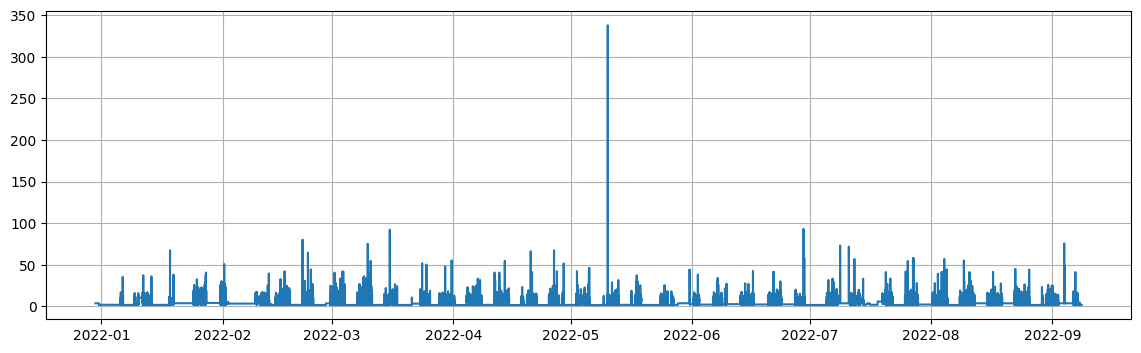

In [123]:
from ts_anom_utils import compute_scores

if not modelp.get('train_predictions', None):
    y1, yhat1 = ts_utils.model_predict( model , window_trn100)
y1, yhat1 = modelp['train_predictions']

if not modelp.get('test_predictions', None):
    y2, yhat2 = ts_utils.model_predict( model , window_tst100)
y2, yhat2 = modelp['test_predictions']


ydf1 = pd.DataFrame(y1, columns=scaler.feature_names_in_[label_slice])
pdf1 = pd.DataFrame(yhat1, columns=scaler.feature_names_in_[label_slice])

ydf2 = pd.DataFrame(y2, columns=scaler.feature_names_in_[label_slice])
pdf2 = pd.DataFrame(yhat2, columns=scaler.feature_names_in_[label_slice])


#ydf = scaler.inverse_transform(ydf)
#pdf = scaler.inverse_transform(pdf)
ret1, error1, se1, errorDF1, escaler1, fscore1 = compute_scores(ydf1, pdf1, errorDF= None)
ret2, error2, se2, errorDF2, escaler2, fscore2 = compute_scores(ydf2, pdf2, errorDF= None)

idx1 = df_trn.index[0:len(ret1)]
idx2 = df_tst.index[0:len(ret2)]
plt.plot(df_trn.index[0:len(ret1)], ret1.norm_score)
errorDF1

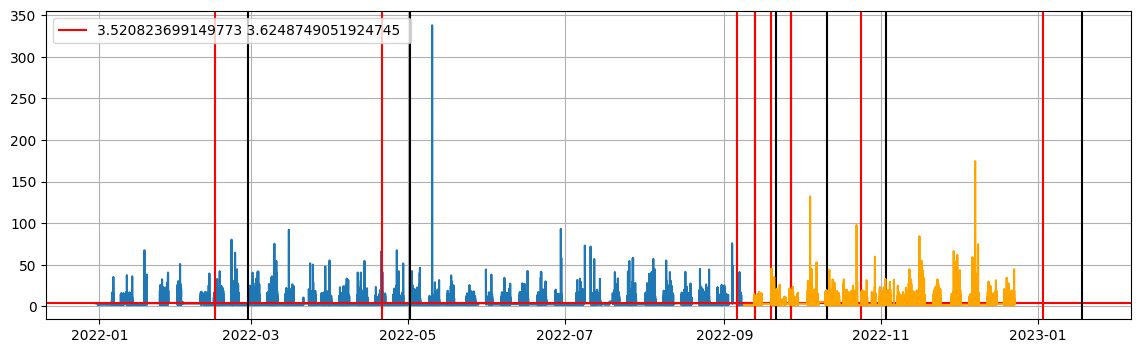

In [146]:
m1 = np.mean(ret1.norm_score)
m2 = np.mean(ret1.score)

score = 'norm_score'
plt.plot(idx1, ret1[score])
plt.axhline(y = m1, color = 'r', linestyle = '-', label=f"{m1} {m2} ")
plt.legend()

for r in dfa.iterrows():
    s = r[1]['Actual Start']
    e = r[1]['Actual End']
    #if (d.year == 2022 and d.month <= 9 and d.day >= 0):
    if (s.year >= 2022 ):
        #print(s,e)
        plt.axvline(s, color = 'r', label = 'axvline - full height')
        plt.axvline(e, color = 'k', label = 'axvline - full height')

plt.plot(idx2, ret2[score], color="orange")

plt.show()

In [136]:
dfa[4:]

,Unnamed: 0,Acquisition Date,Actual End,Actual Start,Basic Finish,Basic Start,Building (combined),Created By,Created On,DAMAGE,...,Wo Type,Wo Type Desc,Work Order,Work Order,Acquisition Value,Actual Cost,Downtime,EQUIP_BUILDING_LATITUDE,EQUIP_BUILDING_LONGITUDE,Number of Breakdowns
4,15086,0.0,2022-02-28,2022-02-15,0,20220215,010 | BUILDING 10 (MANUFACTURING),RMSNETUSR,20220215,NaN,...,503,BLDG. AND GROUNDS,10785880,10785880,0.0,828.87,1.5,32.715748,-97.030548,1
5,15672,0.0,2022-05-02,2022-04-21,0,20220420,010 | BUILDING 10 (MANUFACTURING),DIDUCH,20220420,NaN,...,503,BLDG. AND GROUNDS,10794863,10794863,0.0,822.24,2.0,32.715748,-97.030548,1
6,15256,0.0,2022-09-13,2022-09-06,0,20220906,010 | BUILDING 10 (MANUFACTURING),RMSNETUSR,20220906,NaN,...,503,BLDG. AND GROUNDS,10813058,10813058,0.0,448.30,0.5,32.715748,-97.030548,1
7,15085,0.0,2022-09-21,2022-09-13,0,20220913,010 | BUILDING 10 (MANUFACTURING),LOPEZVM,20220913,NaN,...,503,BLDG. AND GROUNDS,10813938,10813938,0.0,598.51,0.5,32.715748,-97.030548,1
8,15255,0.0,2022-09-27,2022-09-19,0,20220919,010 | BUILDING 10 (MANUFACTURING),RMSNETUSR,20220919,NaN,...,503,BLDG. AND GROUNDS,10814391,10814391,0.0,448.30,1.0,32.715748,-97.030548,1
9,15258,0.0,2022-10-11,2022-09-27,0,20220927,010 | BUILDING 10 (MANUFACTURING),LOPEZVM,20220927,NaN,...,503,BLDG. AND GROUNDS,10815128,10815128,0.0,448.30,1.0,32.715748,-97.030548,1
10,15257,0.0,2022-11-03,2022-10-24,0,20221024,010 | BUILDING 10 (MANUFACTURING),LOPEZVM,20221024,NaN,...,503,BLDG. AND GROUNDS,10819257,10819257,0.0,224.15,2.0,32.715748,-97.030548,1
11,15746,0.0,2023-01-18,2023-01-03,0,20230103,010 | BUILDING 10 (MANUFACTURING),HATTON,20230103,NaN,...,511,Machinery & Equipment,10829266,10829266,0.0,8882.82,80.0,32.715748,-97.030548,1


### The END